# Analyzing an initial dataset

Starting with an archive of stackexchange questions, let's quckly walk through the dataset. 

First, we will load the data. Before loading the csv, make sure you have pre-processed the raw xml using our python package.

In [1]:
import json
from tqdm import tqdm
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ElT
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
import sys
sys.path.append("..")

%matplotlib inline
%load_ext autoreload
%autoreload 2

data_path = Path('../data/writers.csv')
df = pd.read_csv(data_path)

/Users/emmanuel.ameisen/ml_editor/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data format

How are we going to structure it in order to have labels for our model?

We need to measure the quality of a question. For that, we could:
- Use the number of upvotes a question gets
- Use the number of answers a question gets, or whether they get an answer at all
- Use whether an answer was marked as accepted or not

First, let's format our dataset to reconcile questions and associated answers.

How many questions do we have?
How many questions have answers, and how many answers per question on avg?

In [2]:
# Start by changing types to make processing easier
df["AnswerCount"] = df["AnswerCount"].fillna(-1)
df["AnswerCount"] = df["AnswerCount"].astype(int)
df["PostTypeId"] = df["PostTypeId"].astype(int)
df["Id"] = df["Id"].astype(int)
df.set_index("Id", inplace=True, drop=False)

# Add measure of the length of a post
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")
df["text_len"] = df["full_text"].str.len()

# A question is a post of id 1
df["is_question"] = df["PostTypeId"] == 1

## Data quality

Let's try to examine the quality of the dataset we are exploring 

- How much of the data is missing?
- What is the quality of the text?
- Do the answers match the questions?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34330 entries, 1 to 42885
Data columns (total 26 columns):
Unnamed: 0               34330 non-null int64
AcceptedAnswerId         4124 non-null float64
AnswerCount              34330 non-null int64
Body                     34256 non-null object
ClosedDate               969 non-null object
CommentCount             34330 non-null int64
CommunityOwnedDate       186 non-null object
CreationDate             34330 non-null object
FavoriteCount            3307 non-null float64
Id                       34330 non-null int64
LastActivityDate         34330 non-null object
LastEditDate             11201 non-null object
LastEditorDisplayName    614 non-null object
LastEditorUserId         10648 non-null float64
OwnerDisplayName         1976 non-null object
OwnerUserId              32792 non-null float64
ParentId                 25679 non-null float64
PostTypeId               34330 non-null int64
Score                    34330 non-null int64
Tags    

We have a little over 31.000 posts (questions + answers). Why is the body sometimes null? 

In [4]:
df[df["Body"].isna()]

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,...,ParentId,PostTypeId,Score,Tags,Title,ViewCount,body_text,full_text,text_len,is_question
Id,,,,,,,,,,,,,,,,,,,,,
2145,1959,NaN,-1,NaN,NaN,0,NaN,2011-03-22T19:49:56.600,NaN,2145,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2147,1961,NaN,-1,NaN,NaN,0,NaN,2011-03-22T19:51:05.897,NaN,2147,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2215,2029,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:35:10.353,NaN,2215,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2218,2032,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:41:38.677,NaN,2218,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2225,2039,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:58:59.833,NaN,2225,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2227,2041,NaN,-1,NaN,NaN,0,NaN,2011-03-24T20:05:07.753,NaN,2227,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2233,2047,NaN,-1,NaN,NaN,0,NaN,2011-03-24T20:22:44.603,NaN,2233,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2238,2052,NaN,-1,NaN,NaN,0,NaN,2011-03-24T20:38:42.200,NaN,2238,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
3138,2850,NaN,-1,NaN,NaN,0,NaN,2011-06-19T20:18:13.253,NaN,3138,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False


All of the null bodys are of  PostTypeId 4 or 5. The readme file only mentions PostTypeIds of 1 (questions) and 2 (answers). There are 304 rows marked 3 or 4, which we will remove since we do not know what they correspond to.

In [5]:
df = df[df["PostTypeId"].isin([1,2])]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33650 entries, 1 to 42885
Data columns (total 26 columns):
Unnamed: 0               33650 non-null int64
AcceptedAnswerId         4124 non-null float64
AnswerCount              33650 non-null int64
Body                     33650 non-null object
ClosedDate               969 non-null object
CommentCount             33650 non-null int64
CommunityOwnedDate       186 non-null object
CreationDate             33650 non-null object
FavoriteCount            3307 non-null float64
Id                       33650 non-null int64
LastActivityDate         33650 non-null object
LastEditDate             10521 non-null object
LastEditorDisplayName    606 non-null object
LastEditorUserId         9975 non-null float64
OwnerDisplayName         1971 non-null object
OwnerUserId              32117 non-null float64
ParentId                 25679 non-null float64
PostTypeId               33650 non-null int64
Score                    33650 non-null int64
Tags     

Now let's look at questions and accepted answers and see if they match!

In [7]:
questions_with_accepted_answers = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
q_and_a = questions_with_accepted_answers.join(df[["body_text"]], on="AcceptedAnswerId", how="left", rsuffix="_answer")

# Setting this option allows us to display all the data
pd.options.display.max_colwidth = 500
q_and_a[["body_text", "body_text_answer"]][:3]

,body_text,body_text_answer
Id,,
1,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n","When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re..."
2,"What kind of story is better suited for each point of view? Are there advantages or disadvantages inherent to them?\nFor example, writing in the first person you are always following a character, while in the third person you can ""jump"" between story lines.\n","With a story in first person, you are intending the reader to become much more attached to the main character. Since the reader sees what that character sees and feels what that character feels, the reader will have an emotional investment in that character. Third person does not have this close tie; a reader can become emotionally invested but it will not be as strong as it will be in first person.\nContrarily, you cannot have multiple point characters when you use first person without ex..."
3,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n","Try and find a list of agents who write in your genre. Check out their websites!\nFind out if they are accepting new clients. If they aren't, then check out another agent. But if they are, try sending them a few chapters from your story, a brief, and a short cover letter asking them to represent you.\nIn the cover letter mention your previous publication credits. If sent via post, then I suggest you give them a means of reply, whether it be an email or a stamped, addressed envelope.\nAgents ..."


So far so good, and the text seems coherent and human readable potentially except for unescaped newlines characters ("\n")

Let's add to each row the question that has prompted it (when it is an answer


In [8]:

df = df.join(df[["Id", "Title", "body_text", "text_len", "Score", "AcceptedAnswerId"]], on="ParentId", how="left", rsuffix='_question')

This allows us to see all answers for a given question like so

In [9]:
df[df["Id_question"] ==1]

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,...,body_text,full_text,text_len,is_question,Id_question,Title_question,body_text_question,text_len_question,Score_question,AcceptedAnswerId_question
Id,,,,,,,,,,,,,,,,,,,,,
8,5,NaN,-1,"<p>BeginningWriters.com has some good articles for beginning writers.</p>\n\n<p><a href=""http://beginningwriters.com/"">http://beginningwriters.com/</a></p>\n",NaN,0,NaN,2010-11-18T20:45:45.533,NaN,8,...,BeginningWriters.com has some good articles for beginning writers.\nhttp://beginningwriters.com/\n,BeginningWriters.com has some good articles for beginning writers.\nhttp://beginningwriters.com/\n,97,False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",352.0,32.0,15.0
15,10,NaN,-1,"<p>When I'm thinking about where I learned most how to write, I think that <em>reading</em> was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I ...",NaN,3,NaN,2010-11-18T20:50:16.683,NaN,15,...,"When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re...","When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when r...",962,False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",352.0,32.0,15.0
79,65,NaN,-1,"<p>I particularly like <a href=""http://www.advancedfictionwriting.com/art/snowflake.php"" rel=""nofollow"" rel=""nofollow"">The Snowflake Method</a> and most of what Randy writes, including his book.</p>\n",NaN,0,NaN,2010-11-18T23:19:33.157,NaN,79,...,"I particularly like The Snowflake Method and most of what Randy writes, including his book.\n","I particularly like The Snowflake Method and most of what Randy writes, including his book.\n",93,False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",352.0,32.0,15.0
123,106,NaN,-1,"<p>Reading a lot and loving to read are most important of course, but have you tried writing

## Data quantity and distribution

Now that we have linked questions and answers, let's look at some summary statistics

- How many questions do we have?
- How many do we have of each class or type?

In [10]:
has_accepted_answer = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
no_accepted_answers = df[df["is_question"] & (df["AcceptedAnswerId"].isna()) & (df["AnswerCount"]!=0)]
no_answers = df[df["is_question"] & (df["AcceptedAnswerId"].isna()) & (df["AnswerCount"]==0)]

print("%s total questions\n%s without any answer\n%s with at least one answer\n%s with an accepted answer" % (
    len(df[df["is_question"]]),
    len(no_answers),
    len(no_accepted_answers),
    len(has_accepted_answer)))

7971 total questions
144 without any answer
3703 with at least one answer
4124 with an accepted answer


Most questions have an answer, and only half of those answers have been accepted. Whether a question received an accepted answer could be a great label.

Let's dive more into the questions. How long are the questions in our dataset?

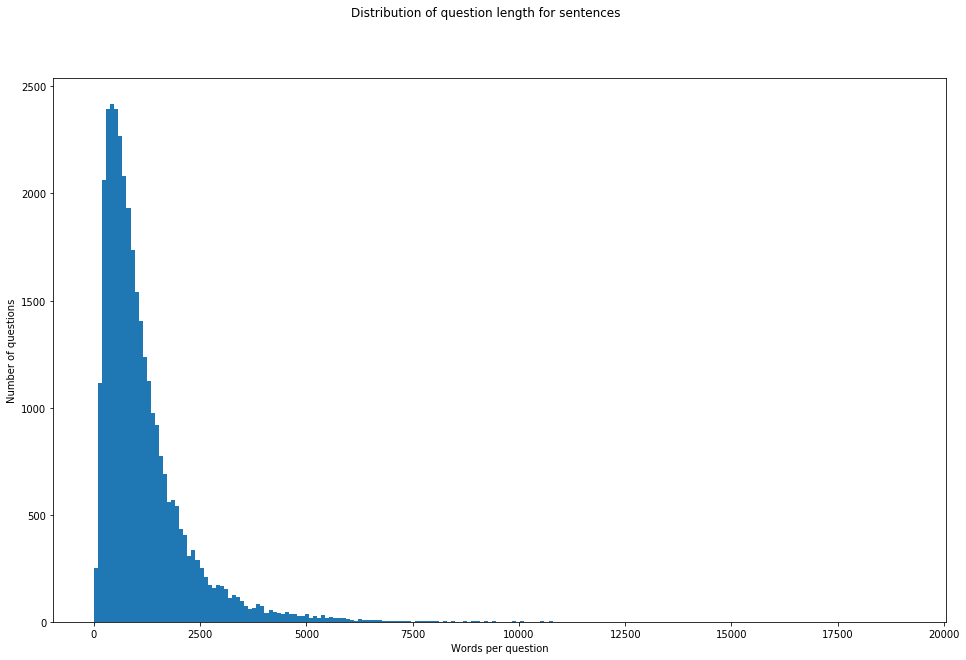

In [11]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Distribution of question length for sentences")
plt.xlabel("Words per question")
plt.ylabel("Number of questions")
q_len = plt.hist(df["text_len"],  bins=200,log=False)

Only a few outliers seem to contain more than two thousand words. Let's zoom in to the shorter questions on the graph.

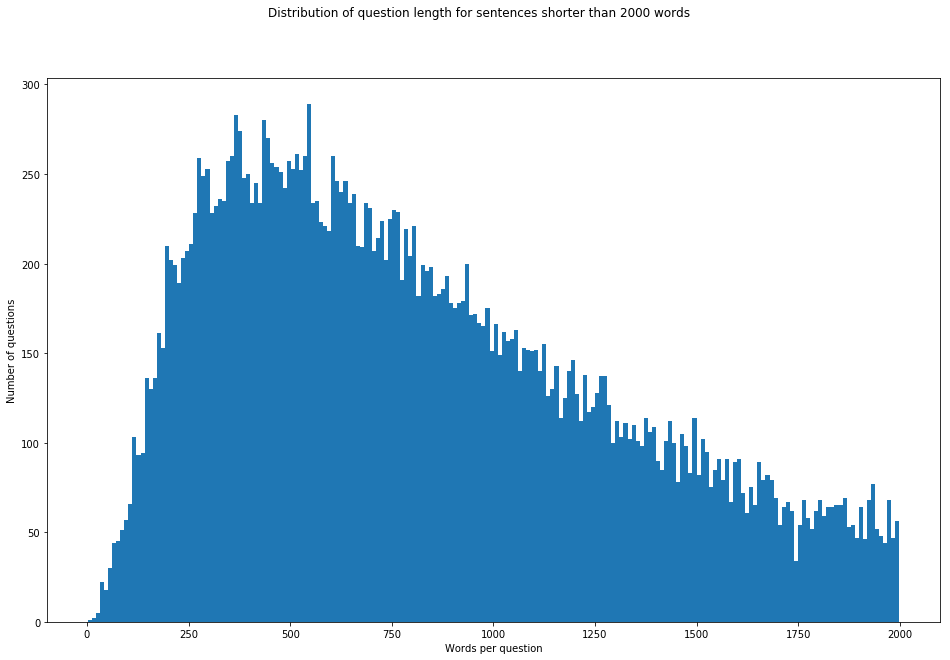

In [12]:
fig = plt.figure(figsize=(16,10))
fig.suptitle(
    "Distribution of question length for sentences shorter than 2000 words")
plt.xlabel("Words per question")
plt.ylabel("Number of questions")
q_len_trunc = plt.hist(df[df["text_len"]<2000]["text_len"], bins=200, log=False)

Now is sentence length predictive of getting many upvotes? In order to gain an intuition, let's separate this plot and overlay the distribution for both answered and unanswered questions.

Text(0, 0.5, 'Percentage of sentences')

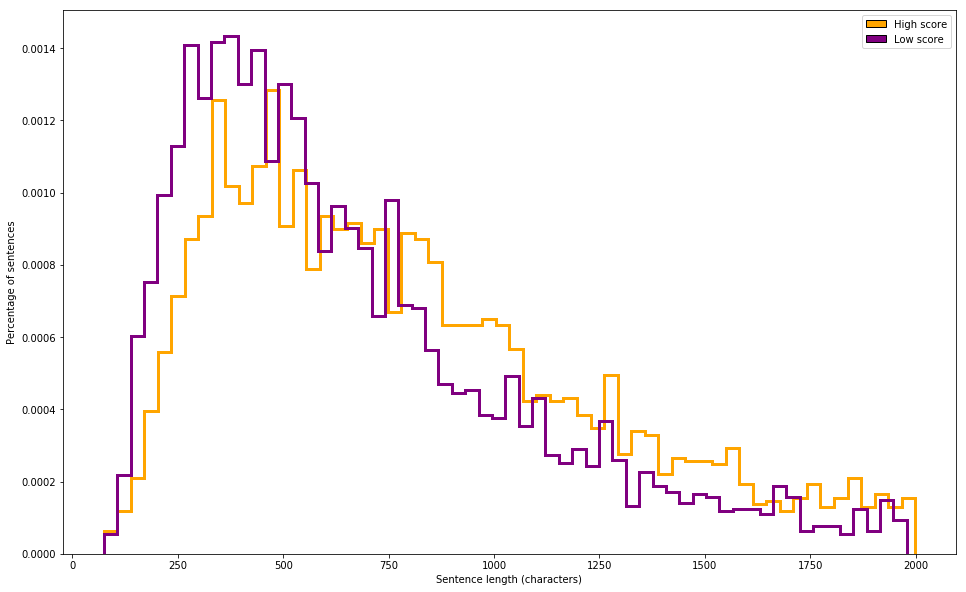

In [17]:
from matplotlib.patches import Rectangle

high_score = df["Score"] > df["Score"].median()
# We filter out really long questions
normal_length = df["text_len"] < 2000

ax = df[df["is_question"] & high_score & normal_length]["text_len"].hist(
    bins=60,
    density=True,
    histtype="step",
    color="orange",
    linewidth=3,
    grid=False,
    figsize=(16, 10),
)

df[df["is_question"] & ~high_score & normal_length]["text_len"].hist(
    bins=60,
    density=True,
    histtype="step",
    color="purple",
    linewidth=3,
    grid=False,
)

handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ["orange", "purple"]
]
labels = ["High score", "Low score"]
plt.legend(handles, labels)
ax.set_xlabel("Sentence length (characters)")
ax.set_ylabel("Percentage of sentences")


It seems that there may be a relatively higher proportion of very short questions amongst unanswered ones. It may be worth trying the feature out for our model

Let's look at the number of answers questions get, and more precicely the distribution of the quantity of answers.

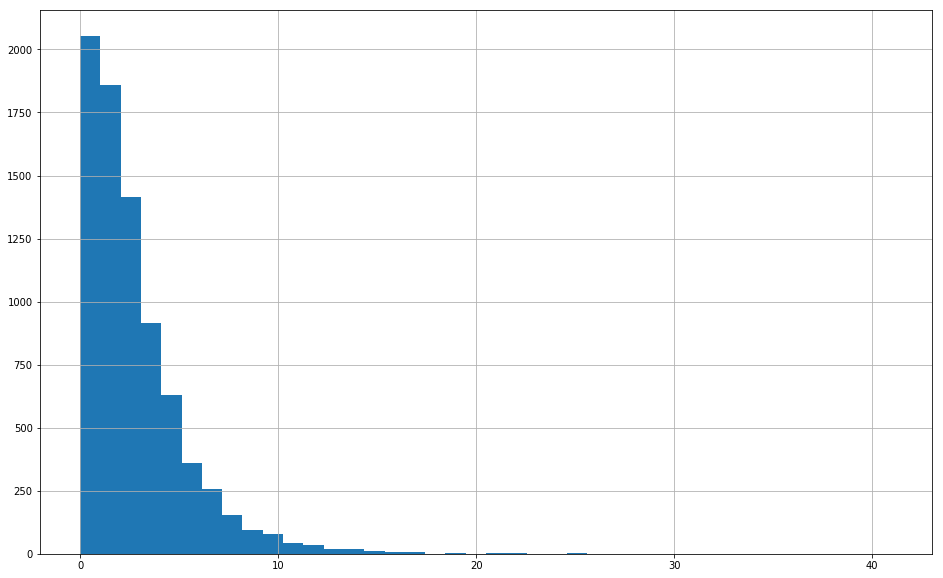

In [14]:
hist = df[df["is_question"]]["AnswerCount"].hist(bins=40, figsize=(16, 10))

Now let's see the distributions of question scores.

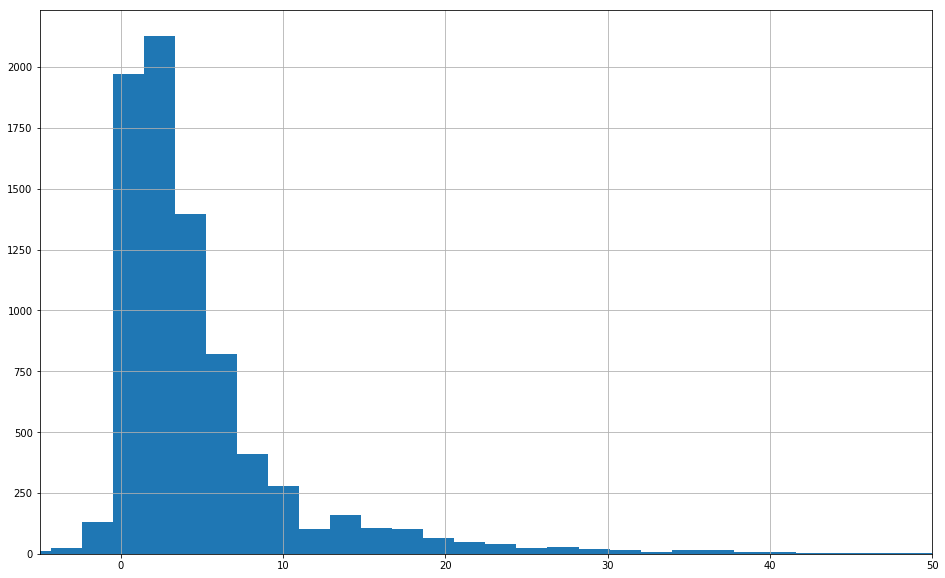

In [15]:
plt.xlim(-5,50)
ax = df[df["is_question"]]["Score"].hist(bins=100, figsize=(16, 10))

Let's build the same plit, but break it down by answered and unanswered as we did before, and try to see if the distributions seem different.

Text(0, 0.5, 'Percentage of sentences')

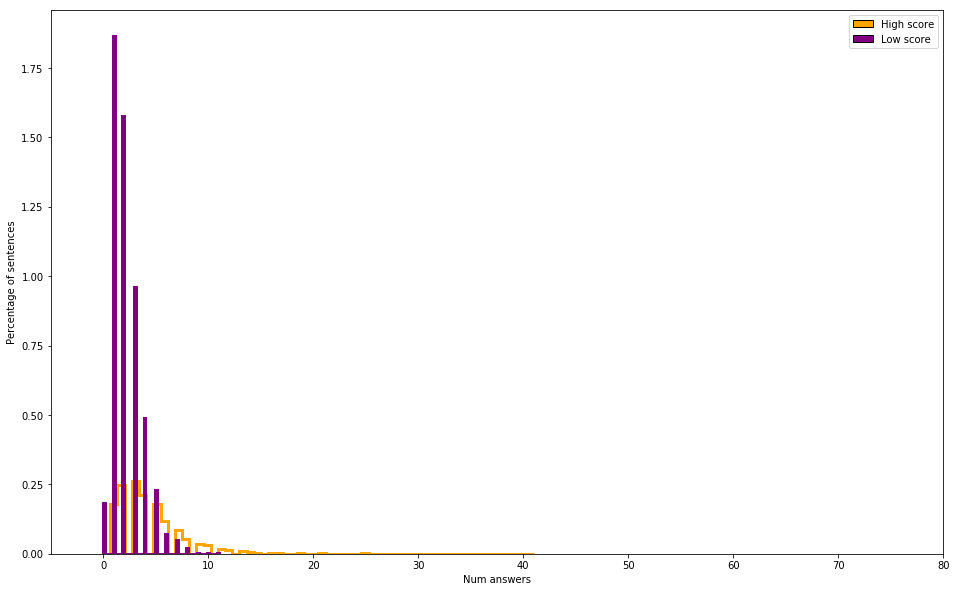

In [16]:
from matplotlib.patches import Rectangle
plt.xlim(-5,80)

ax = df[df["is_question"] &
        (df["Score"] > df["Score"].median())]["AnswerCount"].hist(bins=60,
                                                          density=True,
                                                          histtype="step",
                                                          color="orange",
                                                          linewidth=3,
                                                          grid=False,
                                                          figsize=(16, 10))

df[df["is_question"] &
   ~(df["Score"] > df["Score"].median())]["AnswerCount"].hist(bins=60,
                                                     density=True,
                                                     histtype="step",
                                                     color="purple",
                                                     linewidth=3,
                                                     grid=False)

handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in
           ["orange", "purple"]]
labels = ["High score", "Low score"]
plt.legend(handles, labels)
ax.set_xlabel("Num answers")
ax.set_ylabel("Percentage of sentences")

It seems like questions that get a high score get more answers. The score of a question seems like a good label. The number of answers could be used as a feature to predict the score, but we have to remember this is not a feature we will have at inference time, when we simply get custom text as an input.

In order for our model to work without having such an input, we can either decide to ignore it completely during training, or to use it as a feature during training, and set it as a constant in production. The first approach is simpler, but the second approach can theoretically help our model separate the effect of the number of answers from other style effects which we do want to capture

After this summary exploration, it is time to do a deeper dive!